ACCOUNTING FOR SEASONALITY USING SARIMA(PDQ) MODEL

In [1]:
import pandas as pd 

df = pd.read_csv(r"C:\Users\user\Downloads\air-passengers.csv")

In [2]:
from statsmodels.tsa.seasonal import STL 

decomposition = STL(df['Passengers'], period = 12).fit() #period is equal to frequency m, we have monthly data thus our frequency is 12


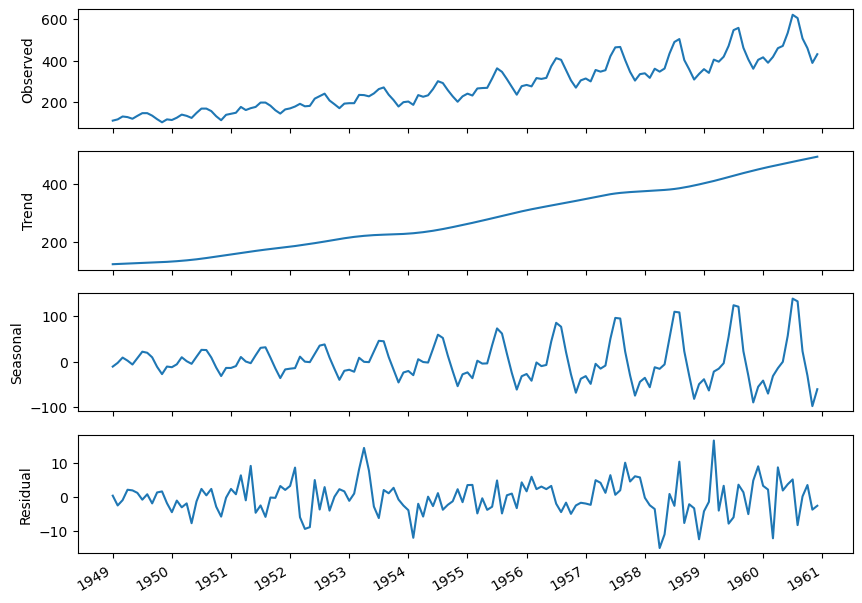

In [3]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')

plt.xticks(np.arange(0,145,12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.show()

Our baseline model will be the ARIMA model to see if we can yield better results when we add the seasonal components later. 

Forecasting with an ARIMA(pdq) model

In [4]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value:{ad_fuller_result[1]}')

#Null hypothesis is not rejected. p-value is greater than 0.05

ADF statistic: 0.8153688792060597
p-value:0.9918802434376411


In [5]:
#difference the series and then test for stationarity once more 

df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value:{ad_fuller_result[1]}')

ADF statistic: -2.829266824169992
p-value:0.0542132902838265


In [6]:
#second order differencing

df_diff = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value:{ad_fuller_result[1]}')

#d=2 
#null hypothesis rejected 

ADF statistic: -16.384231542468527
p-value:2.732891850014085e-29


Since the data is sampled monthly and we know it is seasonal, we can hypothesize that the number of air passengers in January of a given year is likely predictive of the number of air passengers in January of the following year. Since these two points are 12 timesteps apart, we’ll allow the values
of p and q to vary from 0 to 12 in order to potentially capture this seasonal information
in the ARIMA(p,d,q) model. We are working with an ARIMA model, so we’ll set P, D, and Q to 0.

The s in the code is the same as theoretical m, they all denote frequency 

In [7]:
from itertools import product

ps = range(0,13,1)
qs = range(0,13,1)

Ps = [0]
Qs= [0]

d=2
D=0
s=12

ARIMA_order_list  = list(product(ps,qs,Ps,Qs))

In [8]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list:list, d:int, D:int, s:int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order = (order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3],s),
                simple_differencing=False).fit(disp=False)
            
        except:
            continue 
        aic = model.aic
        results.append([order,aic])
    result_df =pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

Despite the fact that we are using the optimize_SARIMA function, we are still fitting an ARIMA model because we specifically set P, D, and Q to 0. For the train set, we’ll take all data points but the last twelve, as they will be used for the test set.

In [9]:
import warnings

warnings.filterwarnings('ignore')

train = df['Passengers'][:-12] #all data points except the last 12, since the last year is used for testing

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)

ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.860517
1,"(11, 4, 0, 0)",1019.012636
2,"(12, 0, 0, 0)",1020.386447
3,"(11, 5, 0, 0)",1020.412171
4,"(11, 1, 0, 0)",1021.016159
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


Residual Analysis of the ARIMA model (11,2,3) 

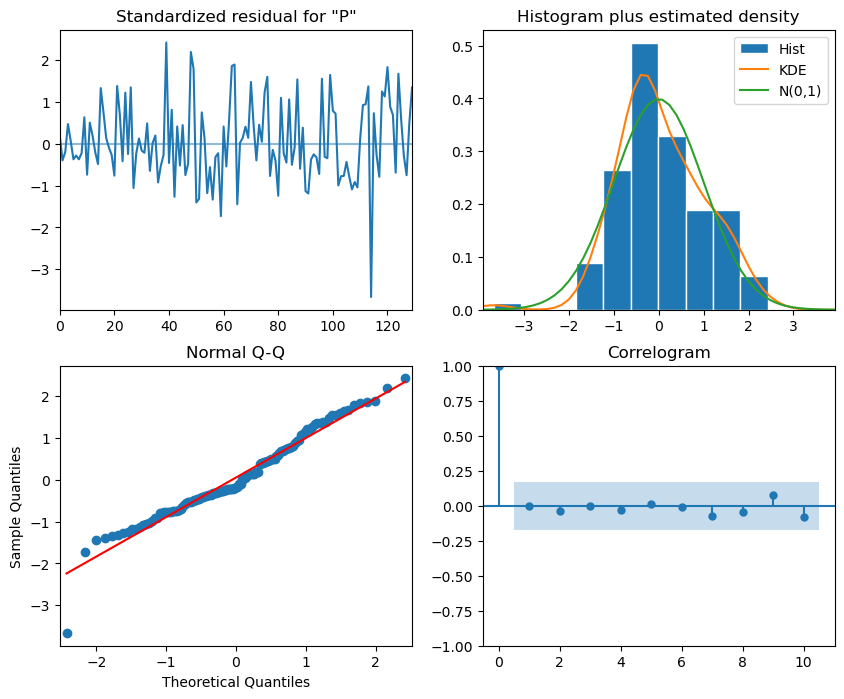

In [11]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

ARIMA_model_fit.plot_diagnostics(figsize  = (10,8))
plt.show()

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid

ljung_box_test = acorr_ljungbox(residuals, lags=12)

ljung_box_test 

,lb_stat,lb_pvalue
1,6.440891,0.011152
2,6.551069,0.037797
3,6.818110,0.077927
4,7.623069,0.106403
5,8.261752,0.142388
6,8.562565,0.199714
7,9.407657,0.224697
8,9.640050,0.291204
9,9.648769,0.379660
10,11.411524,0.326368


p-values are all greater than 0.05 except for the first two values

we reject the null hypothesis, concluding that the residuals are uncorrelated starting at lag 3, meaning our model is not capturing all the information from the data 

In [16]:
test = df.iloc[-12:].copy() #create test set, corresponding to the last 12 data points 

test['naive_seasonal'] = df['Passengers'].iloc[-24:-12].values

ARIMA_pred = ARIMA_model_fit.get_prediction(132,143).predicted_mean #predicitons for each month of 1960 

test['ARIMA_pred'] = ARIMA_pred #append predicitrons to test set 

FORECASTING WITH SARIMA (p,d,q)(P,D,Q)m model 

In [17]:
#check for stationarity 

ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF statistic: 0.8153688792060597
p-value: 0.9918802434376411


In [18]:
#trasnformation by firs order differencing

df_diff = np.diff(df['Passengers'], n=1)

#test for stationarity once more 
ad_fuller_result = adfuller(df_diff)

print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF statistic: -2.829266824169992
p-value: 0.0542132902838265


In [19]:
#seasonal differencing 

seasonal_diff = np.diff(df_diff, n=12) #bc we have monthly data, seasonal diff is 12

ad_fuller_result = adfuller(seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


#reject the null hypothesis, so we can assume that the data is stationary

ADF Statistic: -17.624862360181496
p-value: 3.823046855924265e-30


NOTE: we performed one round of differencing, meaning that d = 1, and one round of seasonal differencing, meaning that D = 1

In [20]:
#DEFINE RANGE OF POSSIBLE VALUES FOR P,Q, P AND Q

ps = range(0, 4 ,1)

qs = range(0, 4, 1)

Ps = range(0, 4, 1)

Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs)) #generates unique combination of orders

train = df['Passengers'][:-12] #all data except last 12 months which acts as the test set 

d=1
D=1
s=12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s) #all sarima models fir on the training set

SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.245386
1,"(2, 1, 2, 1)",894.040682
2,"(2, 1, 1, 3)",894.094972
3,"(1, 0, 1, 2)",894.285767
4,"(0, 1, 1, 2)",894.993083
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.454552
254,"(0, 0, 3, 0)",908.742583


we find that the SARIMA(2,1,1)(1,1,2)12 model has the lowest AIC, which is a value of 892.25. We can fit this model again on the training set to perform residual analysis.

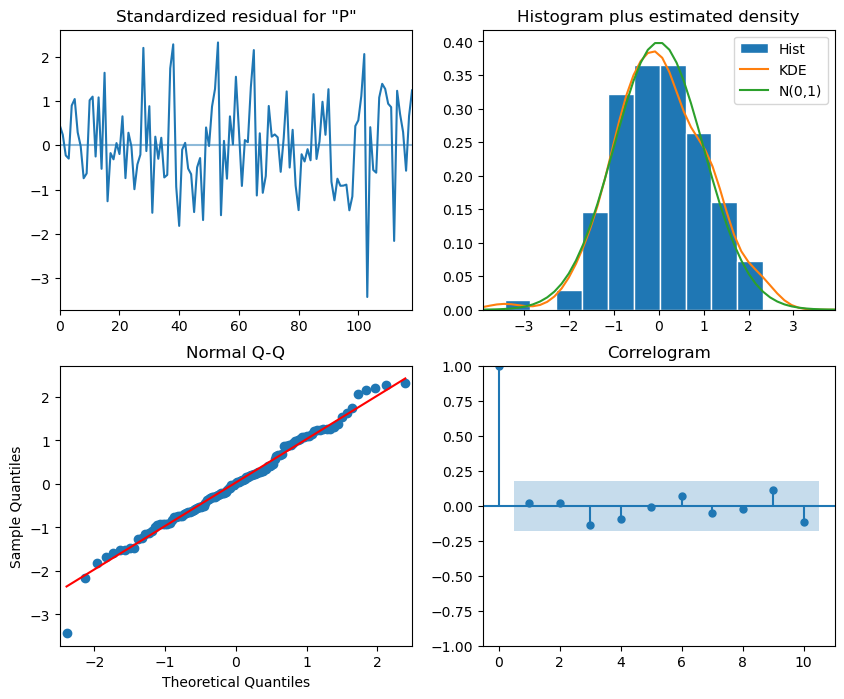

In [22]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)

SARIMA_model_fit = SARIMA_model.fit(disp=False)

SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

plt.show()

In [23]:
#conduct ljung-box test 

from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = SARIMA_model_fit.resid

ljung_box_test = acorr_ljungbox(residuals, lags= np.arange(1, 11,1), return_df=True)

ljung_box_test

,lb_stat,lb_pvalue
1,0.004923,0.944065
2,0.744642,0.689133
3,1.020550,0.796280
4,1.225338,0.873910
5,1.435493,0.920392
6,1.711214,0.944252
7,2.307132,0.940907
8,2.716984,0.950845
9,2.733277,0.973938
10,4.968065,0.893301


> All p-values are greater than 0.05 thus we do not rject the null hypothesis that says the residuals are uncoorelated.
> Our model is ready for forecasting. 

In [24]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132,143).predicted_mean #FORECAST NUMBER OF MONTHLY AIR PASSENGERS FOR THE YEAR 1960 

test['SARIMA_pred'] = SARIMA_pred 

COMPARE PERFOMANCE OF EACH METHOD

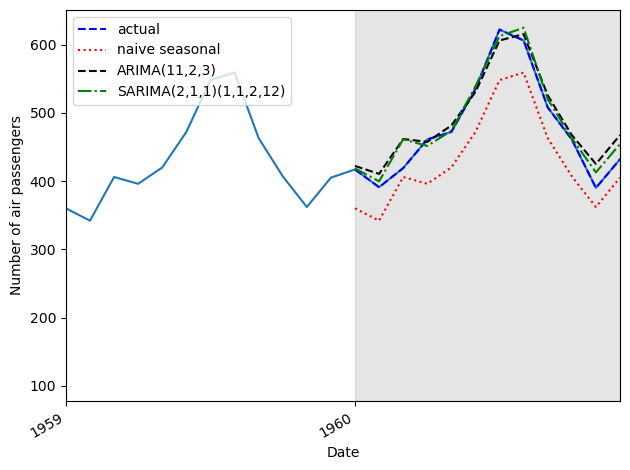

In [26]:
fig,ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b--', label = 'actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label= 'SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132,143, color = 'grey', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0,145,12), np.arange(1949,1962,1))
ax.set_xlim(120,143)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

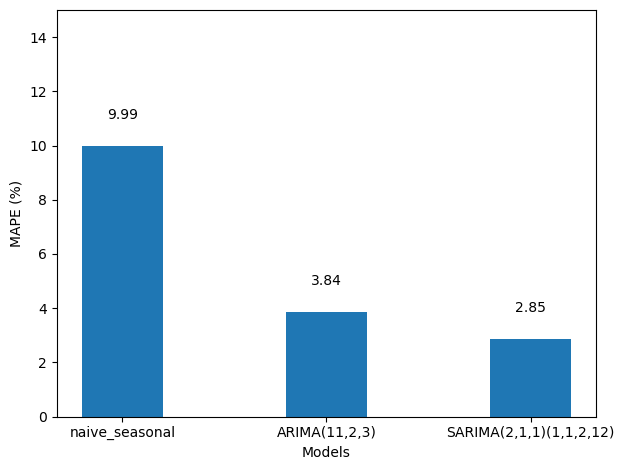

In [27]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

fig, ax = plt.subplots()

x = ['naive_seasonal','ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x,y, width = 0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0,15)

for index, value in enumerate(y):       #display the MAPE as text in plot
    plt.text(x = index, y = value +1, s=str(round(value,2)), ha = 'center')

plt.tight_layout()
plt.show()

SARIMA model performs better as it is well suited for data that has seasonality